In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import string
import json
import pickle
from collections import defaultdict

%matplotlib inline

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests
from urllib2 import urlopen

# Read in Data

Read in scraped data as a dataframe. Data includes anime titles, alternative name, categories, type, date, date of publication, description, rank, rating, list of related animes and studio of production.

In [2]:
data=pd.read_csv("../data/anime_info.csv",sep='\t', index_col=0)

In [3]:
data.shape

(7281, 11)

In [4]:
data[20:50]

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio
1+2=Paradise,NaN,\nOVA (2 eps x 30 min),"[Comedy, Ecchi, Based on a Manga, Gynophobia, ...",NaN,1990,When Yuusuke awakens from a nightmare in which...,1+2=Paradise,"\n Rank #6,187",1.623 of 5 from 571 votes,NaN,J.C.Staff
"1,2,3,4,",NaN,\nWeb (1 ep x 7 min),"[Abstract, Shorts]",NaN,2012,NaN,"1,2,3,4,","\n Rank #6,607",1.031 of 5 from 17 votes,NaN,NaN
10 Nights' Dreams,NaN,\nMovie (1 ep x 6 min),[Shorts],NaN,2004,NaN,10 Nights' Dreams,"\n Rank #6,496",1.322 of 5 from 11 votes,NaN,NaN
10 Tokyo Warriors,Alt title: Tokyo Juushouden,\nOVA (6 eps x 30 min),"[Action, Based on a Novel, Supernatural]",NaN,2004,"Several centuries ago, ten warriors combined t...",10 Tokyo Warriors,"\n Rank #5,778",1.872 of 5 from 360 votes,NaN,Zexcs
100 Byou Cinema: Robo to Shoujo (Kari),NaN,\nWeb (9 eps x 2 min),"[Comedy, Sci Fi, Original Work, Robots]",NaN,2010,NaN,100 Byou Cinema: Robo to Shoujo (Kari),"\n Rank #5,107",2.218 of 5 from 134 votes,NaN,NaN
1001 Nights,NaN,\nMovie (1 ep x 24 min),"[Fantasy, Romance, Abstract, Original Work]",NaN,1998,"Princess Budu sleeps, and dreams. She dreams o...",1001 Nights,"\n Rank #4,719",2.395 of 5 from 662 votes,NaN,Mushi Pro
11eyes,NaN,\nTV (12 eps),"[Action, Ecchi, Fantasy, Seinen, Based on an E...",Fall 2009,2009,"Seven years ago, Kakeru’s sister killed hersel...",11eyes,"\n Rank #3,703","2.811 of 5 from 12,237 votes",[11eyes Special],Dogakobo
11eyes Special,NaN,\nDVD Special (1 ep x 25 min),"[Comedy, Ecchi, Fantasy, Seinen, Based on an E...",NaN,2010,"On a day like any other, Kakeru and Yuko chat ...",11eyes Special,"\n Rank #4,498","2.487 of 5 from 3,453 votes",[11eyes],Dogakobo
"12-Sai.: Kiss, Kirai, Suki",NaN,\nOVA (1 ep x 14 min),"[Romance, Based on a Manga, School Life]",NaN,2014,"The story begins with Hanahi, a sixth-grade gi...","12-Sai.: Kiss, Kirai, Suki","\n Rank #4,626",2.434 of 5 from 251 votes,NaN,Synergy SP
"20min Walk From Nishi-Ogikubo Station, 2 Bedrooms, Living Room, Dining Room, Kitchen, 2mos Deposit, No Pets Allowed",NaN,\n Web (1 ep x 10 min),"[Insects, Japan Animator's Exhibition, Nudity,...",NaN,2014,"20 minutes walk from Nishi Ogikubo Station, 2L...","20min Walk From Nishi-Ogikubo Station, 2 Bedro...","\n Rank #2,962",3.109 of 5 from 160 votes,NaN,Studio Khara


# Cleaning Data and Data Analysis

First Step: 
    1. Within "rating", select ranking out of 5 and pick out number of votes. 
    2. Add separate columns of rating and votes into df
    3. Remove old rating column
    4. Draw histogram of frequency of rating (out of 5)
    

In [5]:
# select vote and numerical ratings within "rating", set rating=0 if doesn't exist
votes=[]
ratings=[]
for row in data.index:
    l=data.ix[row,"rating"].split(" ")
    temp_v=(l[4]).replace(",","")
    # take out "__ needed to calculate an average" in "raing" column
    if (temp_v=="an"):
        ratings.append(0)
        votes.append(0)
    else: 
        votes.append(int(temp_v))
        ratings.append(float(l[0].replace(",","")))

In [6]:
# append new columns of votes and ratings for each anime
data["votes"]=votes
data["ratings"]=ratings

In [7]:
data.ratings.min()

0.0

In [8]:
# remove rating
data.drop("rating", axis=1)
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,"\n Rank #5,996",1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,"\n Rank #2,398","3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,"\n Rank #2,504","3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,"\n Rank #1,576","3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,"\n Rank #3,993",2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691


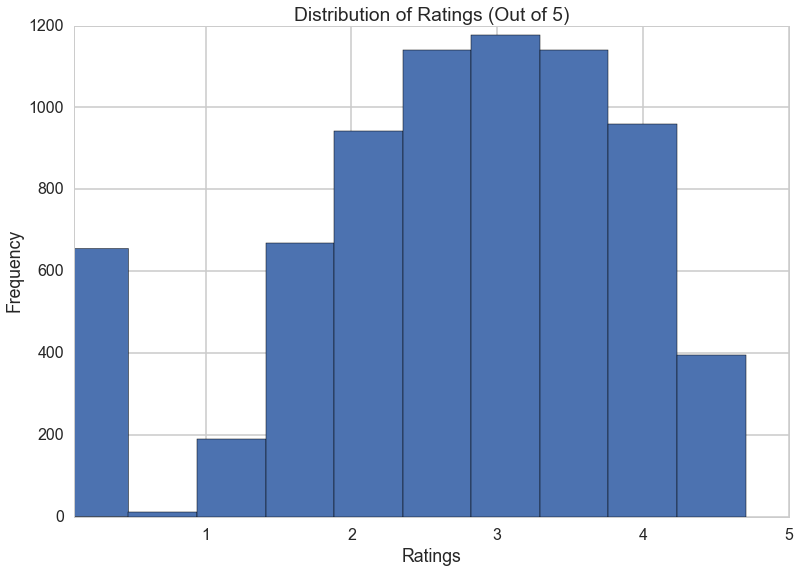

In [9]:
# Ratings distribution
plt.hist(data["ratings"])
plt.title("Distribution of Ratings (Out of 5)")
plt.ylabel("Frequency")
plt.xlabel("Ratings")
plt.xlim(0.1,5.0)
plt.show()

Step 2:
    1. Under "rank" column, pick out numerical rank, set rank=-1 if rank is NaN
    2. Drop old rank column, add new column of "rank" which only includes numerical values

In [10]:
# pick out numerical rank, rank= -1 if rank=NULL
ranks=[]
for row in data.index:
    l=data.ix[row,"rank"].split("#",1)
    if (len(l)>1):
        ranks.append(int(l[1].replace(",","")))
    else:
        ranks.append(-1)

In [11]:
# drop rank column
# add new rank column with numerical values only
# data.drop("rank", axis=1)
data["rank"]=ranks

In [12]:
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691


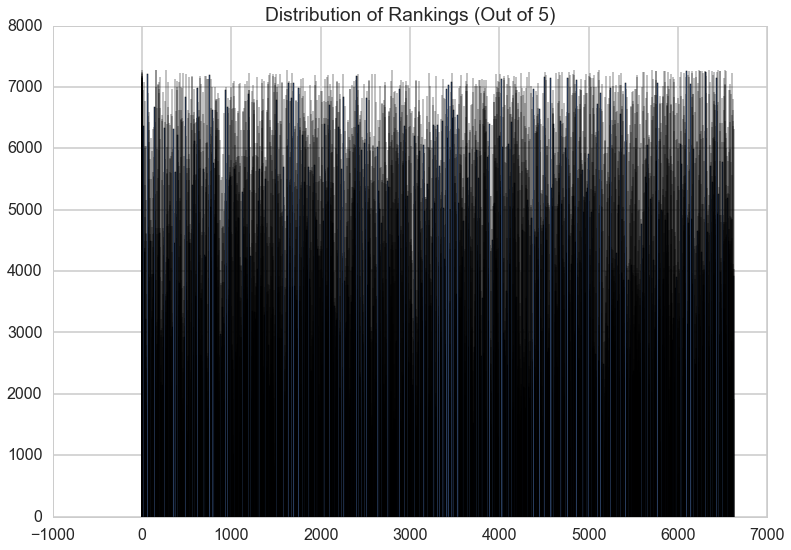

In [13]:
# Rankings distribution
plt.bar(data["rank"], np.arange(len(data["rank"])))
plt.title("Distribution of Rankings (Out of 5)")
plt.show()

Step 3:
    1. Under column atype, pick out number of episodes and length of episodes, calculate total length of movies
    2. Add new column "tlength" to indicate length of anime movies

In [14]:
# pick out number of episodes for each movie, episodes=0 if doesn't exist
episodes=[]
for row in data.index:
    l=data.ix[row,"atype"].split("(",1)
    if (len(l)>1):
        n=l[1:]
        m=n[0].split(" ")
        episodes.append(int(m[0].replace("+","")))
    else:
        episodes.append(0)

In [15]:
# Amend episodes column into dataframe
data["eps"]=episodes
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1


In [16]:
# pick out minutes per episode, emin=0 if does not exist
emin=[]
for row in data.index:
    l=data.ix[row,"atype"].split("x",1)
    if (len(l)>1):
        n=l[1:]
        m=n[0].split(" ")
        emin.append(int(m[1]))
    else:
        emin.append(0)

In [17]:
# add emin (minutes per episode) into dataframe
data["emin"]=emin
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps,emin
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1,6
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11,2
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1,0
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1,93
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1,6


In [18]:
t_length=[]
for i in range(0,len(emin)):
    t_length.append(int(emin[i])*int(episodes[i]))

In [19]:
len(t_length), data.shape

(7281, (7281, 15))

In [20]:
# adding total length of anime movies to column
data["tlength"]=t_length
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps,emin,tlength
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1,6,6
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11,2,22
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1,0,0
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1,93,93
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1,6,6


Step 4: 
    1. Under "atype" column, pick out the type of anime, reset column "type" to include the type only
    2. Under "studio" column, calculate frequency of appearance of studio producing the rated animes
    3. Draw a histogram of frequency of studios

In [21]:
# pick out type of anime
types=[]
for row in data.index:
    l=data.ix[row,"atype"].split("(",1)
    if (len(l)>1):
        types.append(l[0])
    else:
        types.append("NA")

In [22]:
data["type"]=types

In [23]:
# Frequency of Studios
a=pd.value_counts(data['studio'].values, sort=True)
subd=pd.DataFrame(a,a.index.values)
subd.columns=['Frequency']
subd.head(5)


,Frequency
Toei Animation,494
Sunrise,341
MADHOUSE,258
J.C.Staff,245
TMS Entertainment,209


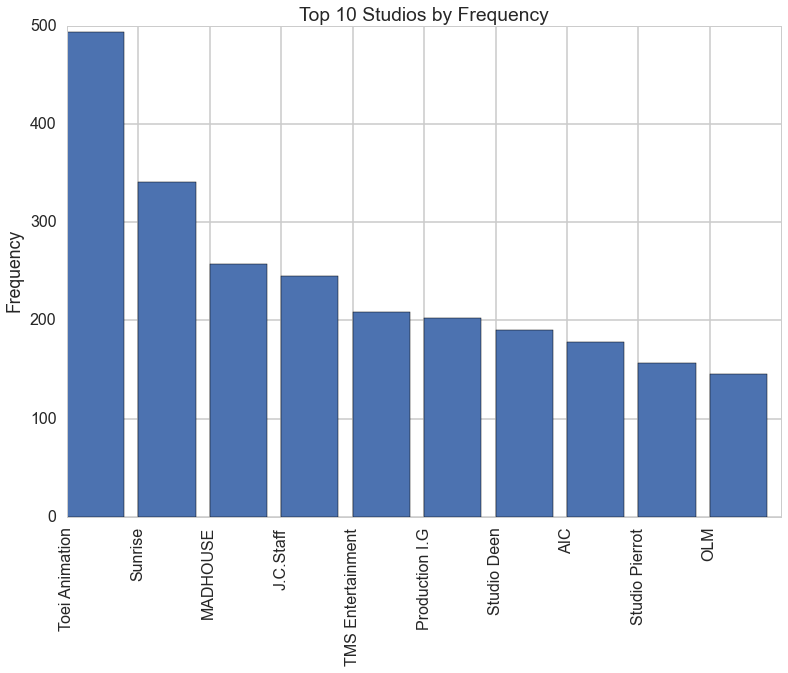

In [24]:
# PLOT TOP 10 STUDIOS BY FREQUENCY
x=np.arange(10)
plt.bar(x,subd.ix[0:10,'Frequency'])
plt.xticks(x, a.index.values[0:10], rotation='vertical')
plt.title("Top 10 Studios by Frequency")
plt.ylabel("Frequency")
plt.show()


Step 5:
    1. Clean "ratings" column by removing non-numerical values, set -1 if there is not enough data
    2. Groupby Studios, calculate ratings of studious, rank average ratings in descending order
    3. Groupby Studios, calculate rankings of studios, rank average ranings in descending order
    4. Compare frequency, ratings, and rankings' correlations among studios

In [25]:
# some ratings said "6 needed to calculate average". Set ratings for these equal to -1
for row in data.index:
    l=data.ix[row,"ratings"]
    if l>5:
        l=-1
        data.ix[row,"ratings"]=l

In [26]:
# arrange studio by highest average ratings
studio_r=data.groupby("studio").aggregate(np.mean)["ratings"]
studio_r=studio_r.order(ascending=False)
subd_studio=pd.DataFrame(studio_r,a.index.values)
subd_studio.columns=['Average Ratings']
subd_studio = subd_studio.sort(['Average Ratings'], ascending=False)
subd_studio.head(5)

,Average Ratings
IMAGIN,4.38800
Studio Chizu,4.38400
Studio Wombat,4.35500
Purple Cow Studio Japan,4.19600
Studio Rikka,4.05825


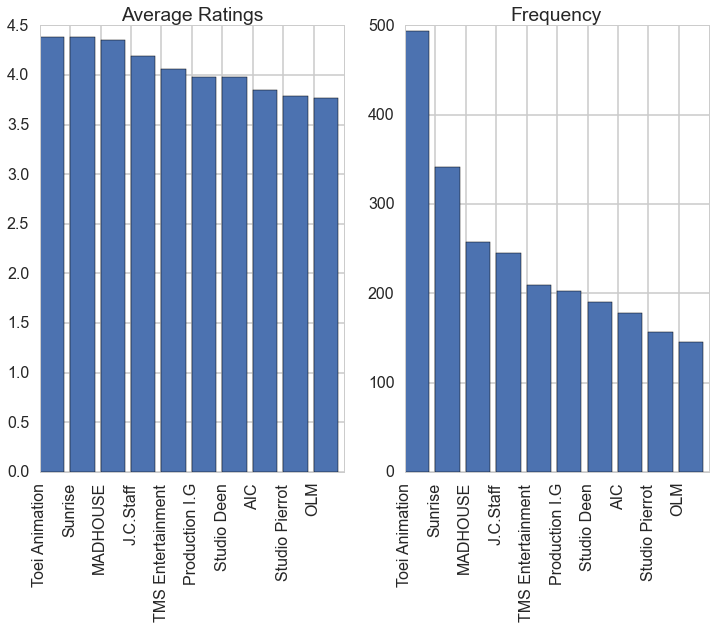

In [27]:
# PLOT STUDIOS BY FREQUENCY AND AVERAGE RATINGS FOR COMPARISONS

fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(12,8))
x=np.arange(10)
axes[0].bar(x,subd_studio.ix[0:10,'Average Ratings'])
axes[0].set_title('Average Ratings')
axes[0].set_xticks(x)
axes[0].set_xticklabels(a.index.values[0:10], rotation=90)
axes[0].set_xticks(x)
axes[0].set_xticklabels(a.index.values[0:10], rotation=90)
axes[1].bar(x,subd.ix[0:10,'Frequency'])
axes[1].set_title('Frequency')
axes[1].set_xticks(x)
axes[1].set_xticklabels(a.index.values[0:10], rotation=90)

In [28]:
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps,emin,tlength,type
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1,6,6,\n Web
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11,2,22,\nDVD Special
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1,0,0,\nOVA
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1,93,93,\nMovie
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1,6,6,\nDVD Special


In [29]:
# arrange studio by highest average ranks
studio_rank=data.groupby("studio").aggregate(np.mean)["rank"]
subd_studio_rank=pd.DataFrame(studio_rank,a.index.values)
subd_studio_rank.columns=['Average Rankings']
subd_studio_rank = subd_studio_rank.sort(['Average Rankings'], ascending=True)
subd_studio_rank.head(5)

,Average Rankings
Kyowa Film,-1
Orange,-1
Automatic Flowers Studio,-1
IMOVE,-1
Buemon,-1


In [30]:
subd_studio_rank.ix[0:10,'Average Rankings']

Kyowa Film                   -1.0
Orange                       -1.0
Automatic Flowers Studio     -1.0
IMOVE                        -1.0
Buemon                       -1.0
Pie in the sky               -1.0
Pine Jam                     -1.0
Shuka                       126.8
IMAGIN                      171.0
Studio Wombat               219.0
Name: Average Rankings, dtype: float64

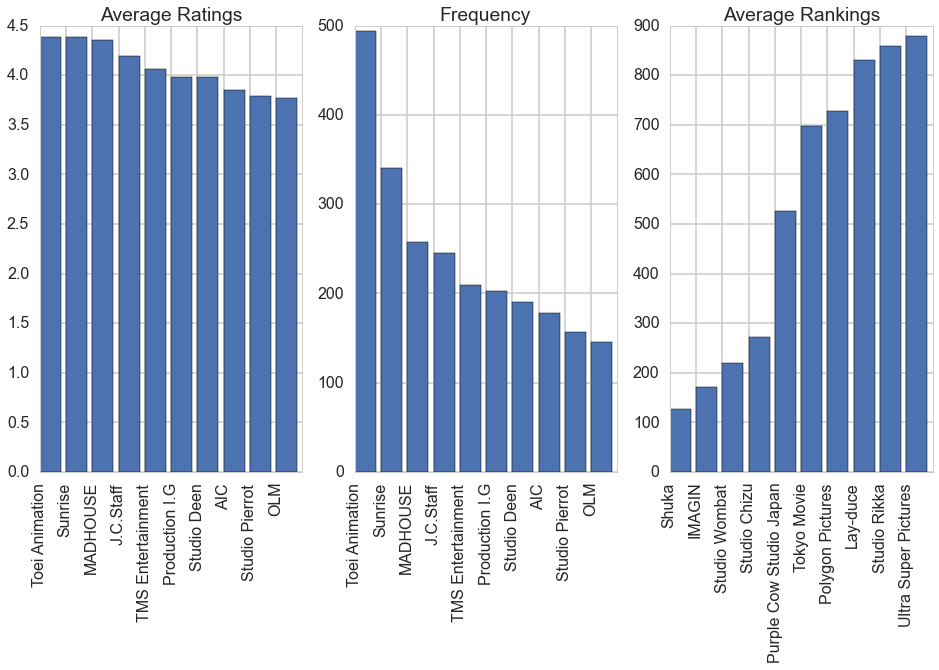

In [31]:
# PLOT TOP 10 STUDIOS BY FREQUENCY, AVERAGE RANKINGS, AND AVERAGE RATINGS FOR COMPARISONS

fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(16,8))
x=np.arange(10)
axes[0].bar(x,subd_studio.ix[0:10,'Average Ratings'])
axes[0].set_title('Average Ratings')
axes[0].set_xticks(x)
axes[0].set_xticklabels(a.index.values[0:10], rotation=90)
axes[1].bar(x,subd.ix[0:10,'Frequency'])
axes[1].set_title('Frequency')
axes[1].set_xticks(x)
axes[1].set_xticklabels(a.index.values[0:10], rotation=90)
axes[2].bar(x,subd_studio_rank.ix[7:17,'Average Rankings']) # first 7 have -1 ranking, or no ranking
axes[2].set_title('Average Rankings')
axes[2].set_xticks(x)
axes[2].set_xticklabels(subd_studio_rank.index.values[7:17], rotation=90)

Step 6:
    1. Clean "atype" column, calculate frequency of types of animes
    2. Groupby type of anime, calculate average ratings for each type, rank average ratings in descending order
    3. Groupby type of anime, calculate average rankings for each type, rank average rankings in descending order
    4. Observe correlations of top types by ratings, rankings, and frequency

In [32]:
# remove trailing spaces in type
for row in data.index:
    l=data.ix[row,"type"].strip(" ")
    l=l.replace(" ","")
    data.ix[row,"type"]=l
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps,emin,tlength,type
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1,6,6,\nWeb
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11,2,22,\nDVDSpecial
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1,0,0,\nOVA
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1,93,93,\nMovie
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1,6,6,\nDVDSpecial


In [33]:
# Frequency of types
t=pd.value_counts(data['type'].values, sort=True)
subd_t=pd.DataFrame(t,t.index.values)
subd_t.columns=['Frequency']
subd_t.head(5)

,Frequency
\nTV,2715
\nOVA,1450
\nMovie,1239
\nDVDSpecial,528
\nMusicVideo,328


In [106]:
subd_t.shape

(9, 1)

In [34]:
# Type vs ratings
type_rating=data.groupby("type").aggregate(np.mean)["ratings"]
type_rating=type_rating.order(ascending=False)
subd_type_rating=pd.DataFrame(type_rating,type_rating.index.values)
subd_type_rating.columns=['Average Ratings']
subd_type_rating = subd_type_rating.sort(['Average Ratings'], ascending=False)
subd_type_rating.head(5)

,Average Ratings
\nTV,2.980532
\nTVSpecial,2.864709
\nDVDSpecial,2.861572
\nOVA,2.717472
\nMovie,2.710854


In [35]:
# Type vs rankings
type_rank=data.groupby("type").aggregate(np.mean)["rank"]
type_rank=type_rank.order(ascending=False)
subd_type_rank=pd.DataFrame(type_rank,type_rating.index.values)
subd_type_rank.columns=['Average Rankings']
subd_type_rank = subd_type_rank.sort(['Average Rankings'], ascending=True)
subd_type_rank.head(5)

,Average Rankings
NA,10.949367
\nMovie,2745.891848
\nTVSpecial,2779.708904
\nTV,2786.073665
\nDVDSpecial,3174.492424


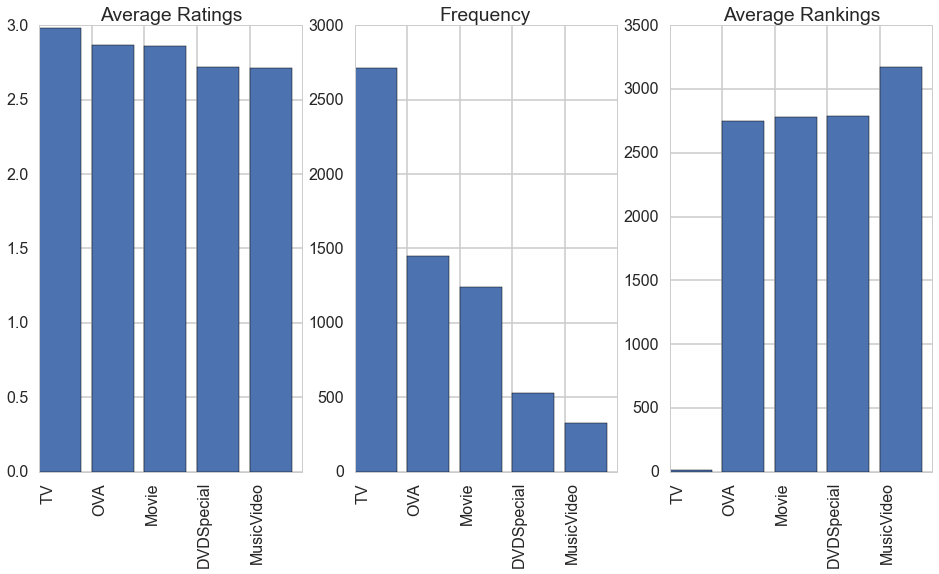

In [36]:
# PLOT TOP 5 TYPES BY FREQUENCY, AVERAGE RANKINGS, AND AVERAGE RATINGS FOR COMPARISONS

fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(16,8))
x=np.arange(5)
axes[0].bar(x,subd_type_rating.ix[0:5,'Average Ratings'])
axes[0].set_title('Average Ratings')
axes[0].set_xticks(x)
axes[0].set_xticklabels(t.index.values[0:5], rotation=90)
axes[1].bar(x,subd_t.ix[0:5,'Frequency'])
axes[1].set_title('Frequency')
axes[1].set_xticks(x)
axes[1].set_xticklabels(t.index.values[0:5], rotation=90)
axes[2].bar(x,subd_type_rank.ix[0:5,'Average Rankings'])
axes[2].set_title('Average Rankings')
axes[2].set_xticks(x)
axes[2].set_xticklabels(t.index.values[0:5], rotation=90)

Step 7: 
    1. Scatter tlength and ratings to find any correlation
    2. Scatter tlength and rankings to find any correlation
    3. Observe and record any correlation

In [37]:
# Tlength vs ratings
subd_length=pd.DataFrame(data["tlength"], data.index.values)
subd_length["ratings"]=data["ratings"]
subd_length

,tlength,ratings
(Making of) Evangelion: Another Impact,6,1.743
+A-Channel,22,3.334
.hack//G.U. Returner,0,3.291
.hack//G.U. Trilogy,93,3.671
.hack//G.U. Trilogy Parody,6,2.691
.hack//GIFT,0,2.646
.hack//LIMINALITY,0,3.064
.hack//Legend Of The Twilight,0,3.078
.hack//Quantum,0,3.933
.hack//Quantum Specials,9,2.916


In [38]:
subd_length.tlength.max()

18080L

C:\Users\tle1925\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


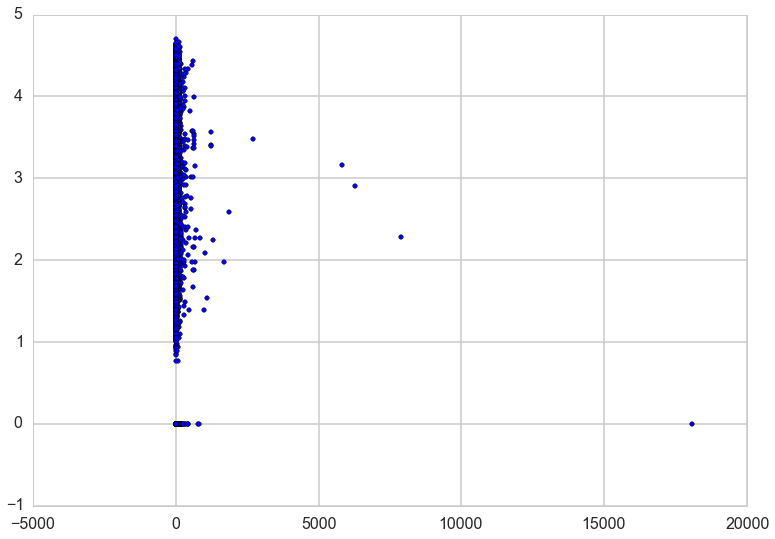

In [39]:
plt.scatter(subd_length["tlength"], subd_length["ratings"])

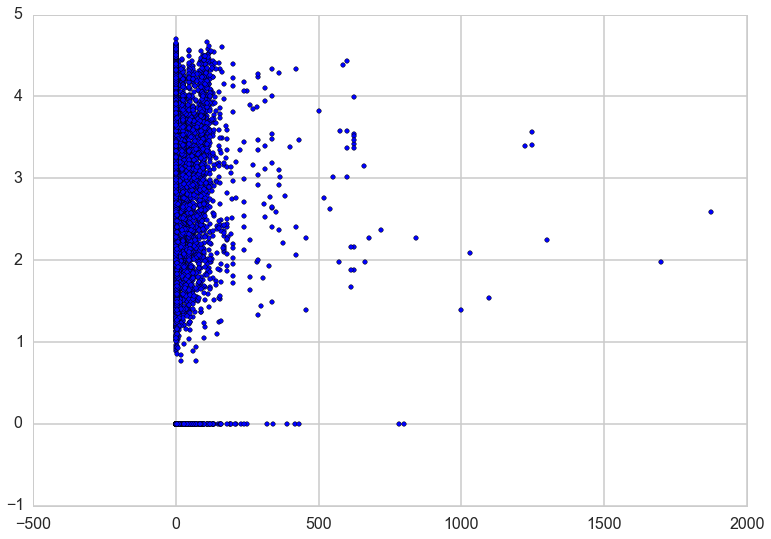

In [40]:
# zoom in to data with lower tlength values
temp_subd=subd_length[subd_length["tlength"]<2000]
plt.scatter(temp_subd["tlength"], temp_subd["ratings"])

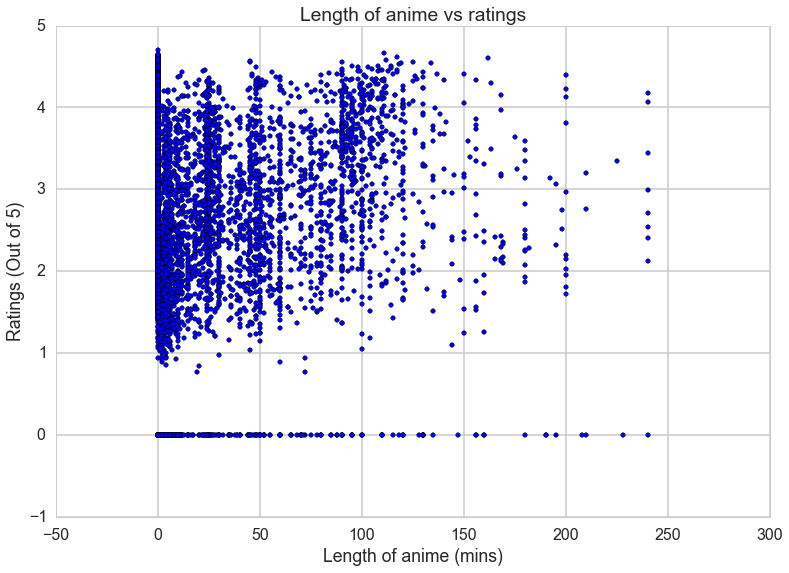

In [41]:
# zoom more into data with lower tlength values
temp_subd1=subd_length[subd_length["tlength"]<250]
plt.scatter(temp_subd1["tlength"], temp_subd1["ratings"])
plt.title("Length of anime vs ratings")
plt.xlabel("Length of anime (mins)")
plt.ylabel("Ratings (Out of 5)")


In [42]:
# Tlength vs rankings
subd_length_rank=pd.DataFrame(data["tlength"], data.index.values)
subd_length_rank["rankings"]=data["rank"]
subd_length_rank

,tlength,rankings
(Making of) Evangelion: Another Impact,6,5996
+A-Channel,22,2398
.hack//G.U. Returner,0,2504
.hack//G.U. Trilogy,93,1576
.hack//G.U. Trilogy Parody,6,3993
.hack//GIFT,0,4108
.hack//LIMINALITY,0,3073
.hack//Legend Of The Twilight,0,3039
.hack//Quantum,0,974
.hack//Quantum Specials,9,3441


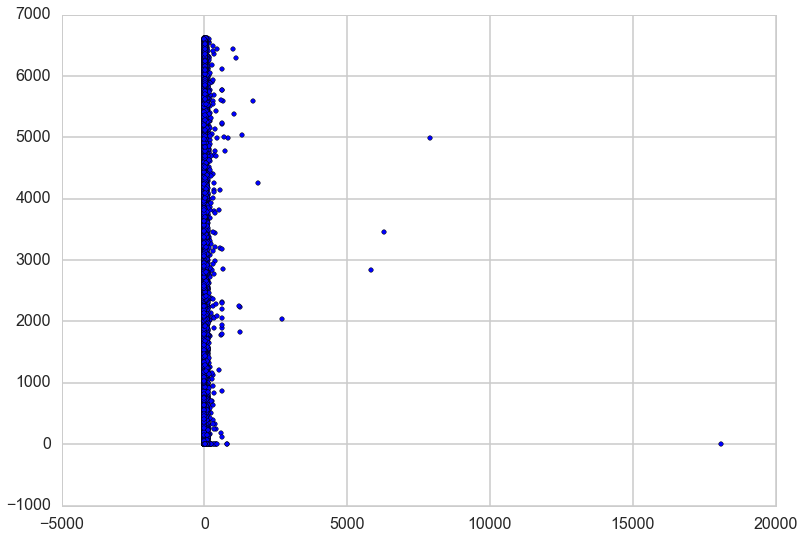

In [43]:
plt.scatter(subd_length_rank["tlength"], subd_length_rank["rankings"])

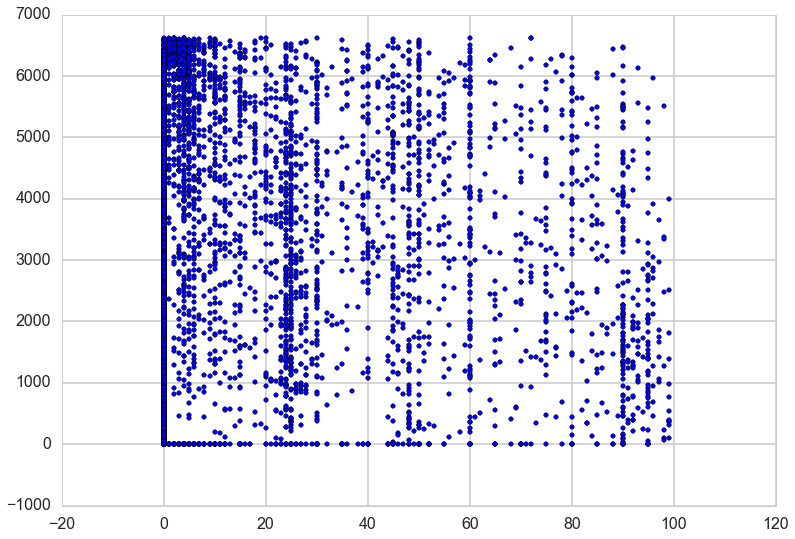

In [44]:
# zoom more into data with lower tlength values
temp_subdl=subd_length_rank[subd_length_rank["tlength"]<100]
plt.scatter(temp_subdl["tlength"], temp_subdl["rankings"])

In [45]:
# episodes vs rankings
subd_ep_rank=pd.DataFrame(data["eps"], data.index.values)
subd_ep_rank["rankings"]=data["rank"]
subd_ep_rank.head(5)

,eps,rankings
(Making of) Evangelion: Another Impact,1,5996
+A-Channel,11,2398
.hack//G.U. Returner,1,2504
.hack//G.U. Trilogy,1,1576
.hack//G.U. Trilogy Parody,1,3993


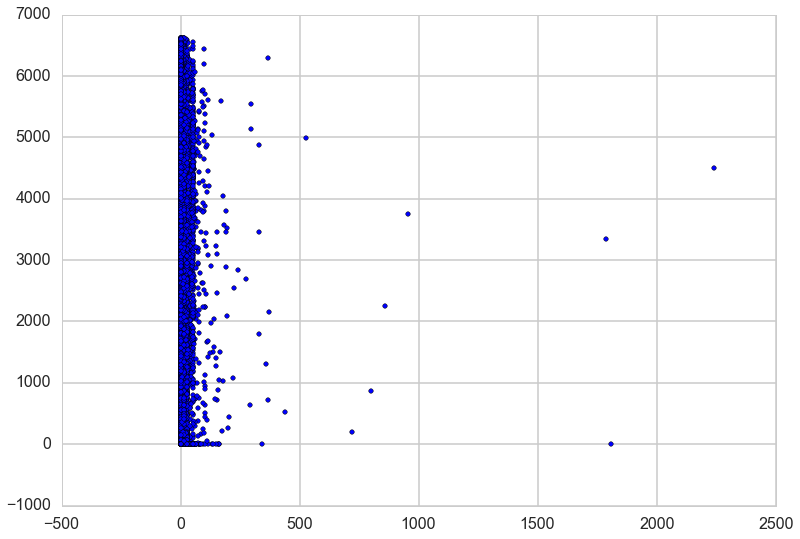

In [46]:
plt.scatter(subd_ep_rank['eps'],subd_ep_rank['rankings'])

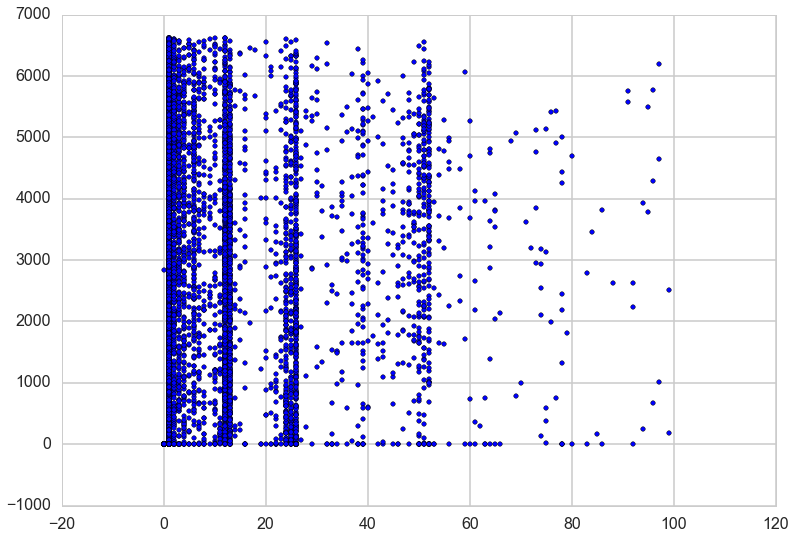

In [47]:
temp_subdep=subd_ep_rank[subd_ep_rank['eps']<100]
plt.scatter(temp_subdep['eps'], temp_subdep['rankings'])

Step 8: 
    1. Scatter episodes and ratings to find any correlation
    2. Scatter episodes and rankings to find any correlation
    3. Observe and record any correlation

In [48]:
# episodes vs ratings
subd_ep_rating=pd.DataFrame(data["eps"], data.index.values)
subd_ep_rating["ratings"]=data["ratings"]
subd_ep_rating.head(5)

,eps,ratings
(Making of) Evangelion: Another Impact,1,1.743
+A-Channel,11,3.334
.hack//G.U. Returner,1,3.291
.hack//G.U. Trilogy,1,3.671
.hack//G.U. Trilogy Parody,1,2.691


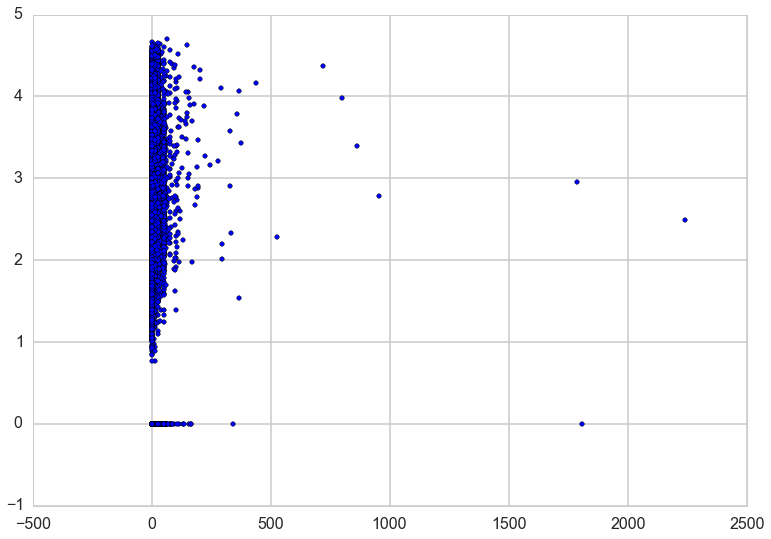

In [49]:
plt.scatter(subd_ep_rating['eps'],subd_ep_rating['ratings'])

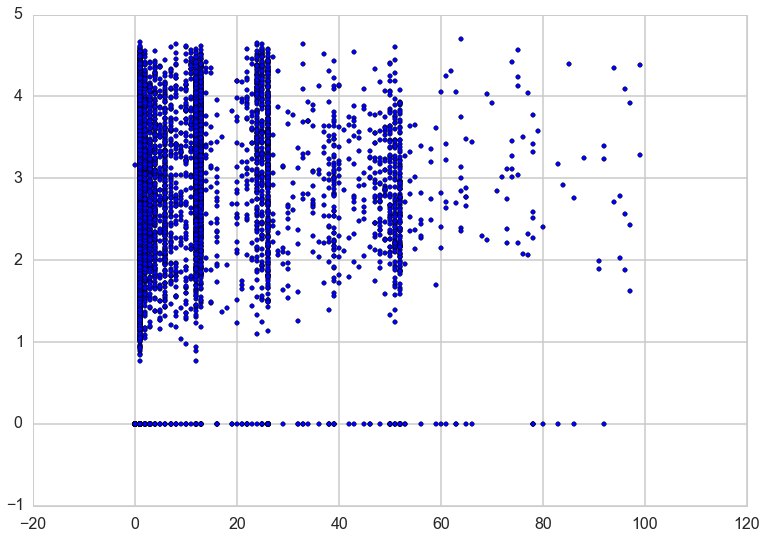

In [50]:
temp_subdep1=subd_ep_rating[subd_ep_rating['eps']<100]
plt.scatter(temp_subdep1['eps'], temp_subdep1['ratings'])

Step 9: 
    1. Scatter votes and ratings to find any correlation
    2. Scatter votes and rankings to find any correlation
    3. Observe and record any correlation

In [51]:
# Votes vs ratings
subd_v_rating=pd.DataFrame(data["votes"], data.index.values)
subd_v_rating["ratings"]=data["ratings"]
subd_v_rating.head(5)

,votes,ratings
(Making of) Evangelion: Another Impact,153,1.743
+A-Channel,1192,3.334
.hack//G.U. Returner,2021,3.291
.hack//G.U. Trilogy,2814,3.671
.hack//G.U. Trilogy Parody,714,2.691


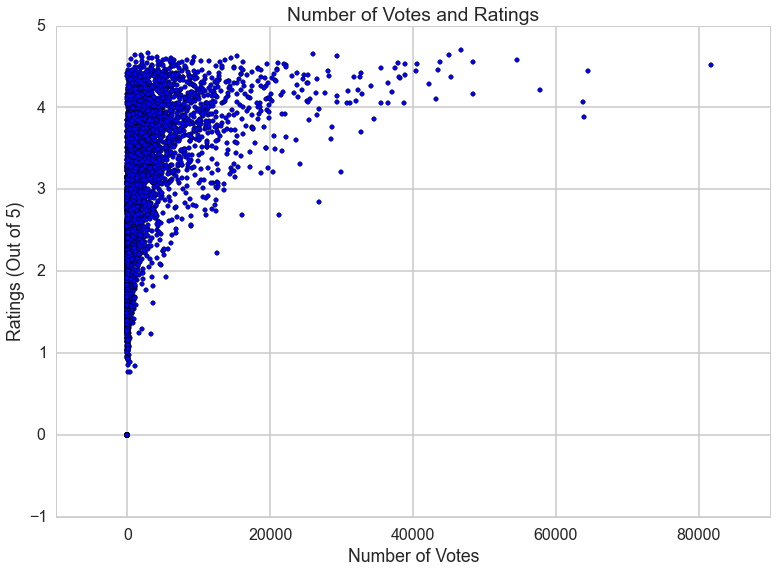

In [52]:
plt.scatter(subd_v_rating["votes"], subd_v_rating["ratings"])
plt.title("Number of Votes and Ratings")
plt.xlabel("Number of Votes")
plt.ylabel("Ratings (Out of 5)")

In [53]:
# Votes s rankings
subd_v_rank=pd.DataFrame(data["votes"], data.index.values)
subd_v_rank["rankings"]=data["rank"]
subd_v_rank.head(5)

,votes,rankings
(Making of) Evangelion: Another Impact,153,5996
+A-Channel,1192,2398
.hack//G.U. Returner,2021,2504
.hack//G.U. Trilogy,2814,1576
.hack//G.U. Trilogy Parody,714,3993


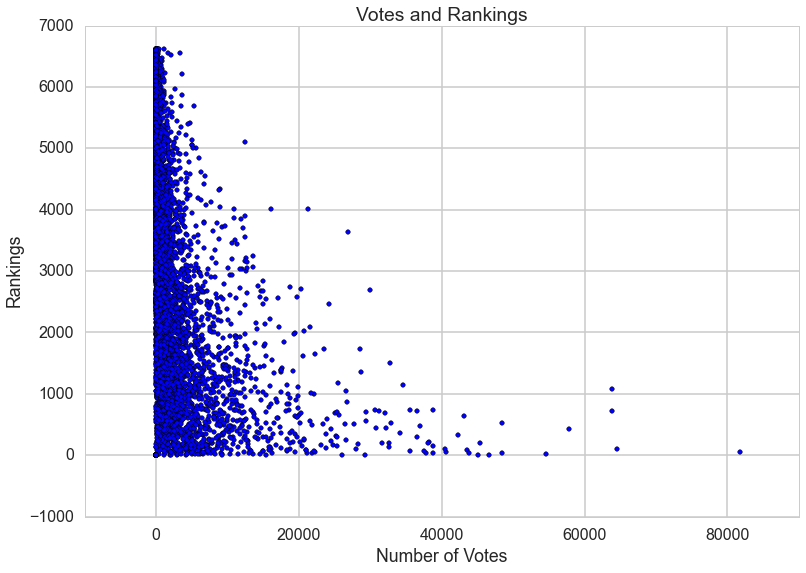

In [54]:
plt.scatter(subd_v_rank["votes"], subd_v_rank["rankings"])
plt.title("Votes and Rankings")
plt.xlabel("Number of Votes")
plt.ylabel("Rankings")

Step 10: 
    1. Scatter date_pub and ratings to find any correlation
    2. Scatter date_pub and rankings to find any correlation
    3. Observe and record any correlation

In [55]:
# Date_pub vs ratings and rankings
subd_dp=pd.DataFrame(data["date_pub"], data.index.values)
subd_dp["rankings"]=data["rank"]
subd_dp["ratings"]=data["ratings"]
subd_dp.head(5)

,date_pub,rankings,ratings
(Making of) Evangelion: Another Impact,2015,5996,1.743
+A-Channel,2011,2398,3.334
.hack//G.U. Returner,2007,2504,3.291
.hack//G.U. Trilogy,2008,1576,3.671
.hack//G.U. Trilogy Parody,2008,3993,2.691


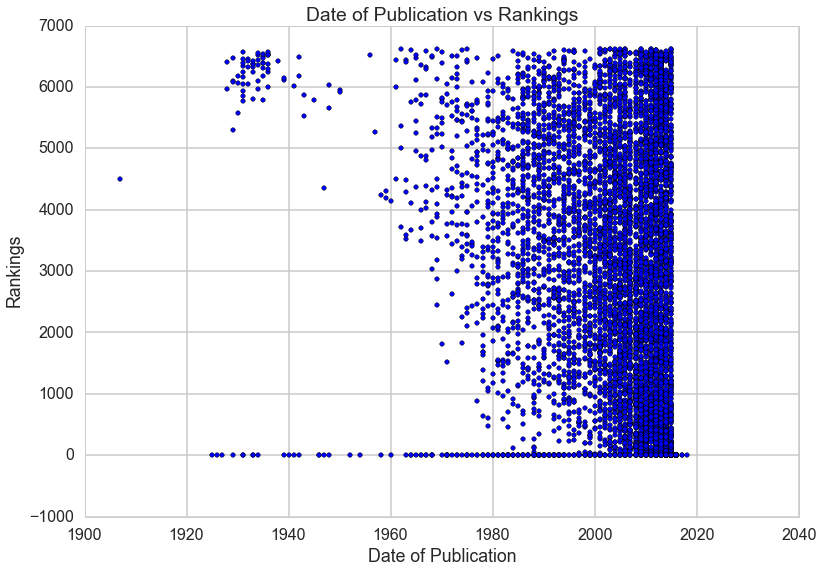

In [56]:
# date_pub vs rankings
plt.scatter(subd_dp["date_pub"], subd_dp["rankings"])
plt.title("Date of Publication vs Rankings")
plt.xlabel("Date of Publication")
plt.ylabel("Rankings")

We can see significant movement of rankings every ~10 year interval, hence we assume that there's a slight improvement in
rankings after each decade

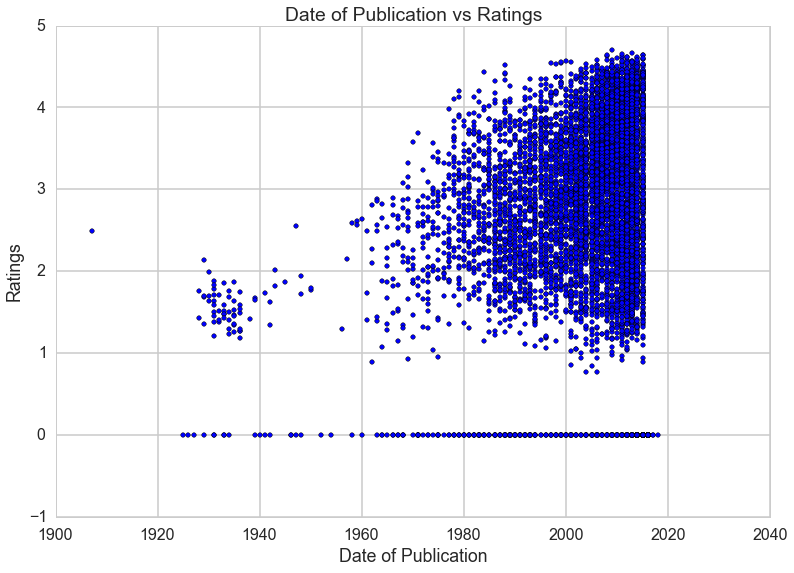

In [57]:
plt.scatter(subd_dp["date_pub"], subd_dp["ratings"])
plt.title("Date of Publication vs Ratings")
plt.xlabel("Date of Publication")
plt.ylabel("Ratings")

In [58]:
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps,emin,tlength,type
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1,6,6,\nWeb
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11,2,22,\nDVDSpecial
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1,0,0,\nOVA
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1,93,93,\nMovie
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1,6,6,\nDVDSpecial


Step 11: 
    1. Groupby categories, calculate frequency of categories
    2. Groupby categories, calculate average ratings, sort in descending order
    3. Groupby categories, calculate average rankings, sort in descending order
    4. Observe and record any correlation among Top 10 categories by frequency, average ratings, average ranknigs

In [59]:
# get categories list
cats=[]
for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        l="NA"
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(",")
        for word in n:
            word=word.strip(" ")
            cats.append(word)

In [104]:
c=pd.value_counts(cats, sort=True)
subd_cat=pd.DataFrame(c, c.index.values)
subd_cat.columns=['Frequency']
subd_cat=subd_cat.sort()
subd_cat.head(5)


,Frequency
Abstract,65
Action,1428
Adventure,591
Age Gap,8
Age Transformation,7


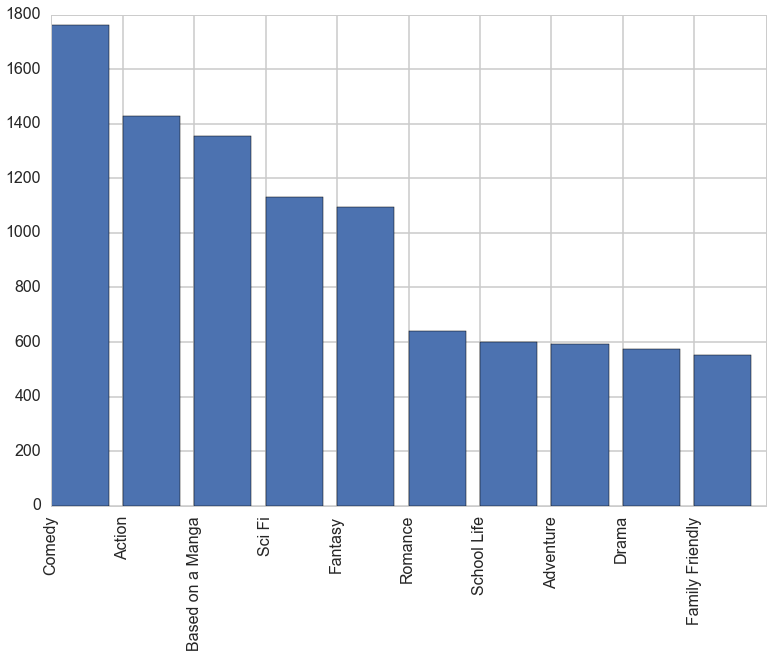

In [61]:
# PLOT TOP 10 CATEGORIES BY FREQUENCY
subd_cat_freq=subd_cat.sort(["Frequency"], ascending=False)
x=np.arange(10)
plt.bar(x,subd_cat_freq.ix[0:10,'Frequency'])
plt.xticks(x, c.index.values[0:10], rotation='vertical')
plt.show()

In [62]:
# categories vs ratings
from collections import defaultdict
cat_rat=defaultdict(int)
for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        l="NA"
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(",")
        for word in n:
            word=word.strip(" ")
            cat_rat[word]+=data.ix[row,"ratings"]

In [63]:
subd_cat_rating=pd.DataFrame([cat_rat]).T
subd_cat_rating.columns=['Total Ratings']
subd_cat_rating = subd_cat_rating.sort()
subd_cat_rating["Frequency"]=subd_cat["Frequency"]
subd_cat_rating["Average Ratings"]=subd_cat_rating["Total Ratings"]/subd_cat["Frequency"]
subd_cat_rating = subd_cat_rating.sort(['Average Ratings'], ascending=False)
subd_cat_rating.head(5)

,Total Ratings,Frequency,Average Ratings
Yaoi Hand Syndrome,33.189,8,4.148625
Youkai,4.055,1,4.055000
Age Gap,31.725,8,3.965625
Terrorism,43.020,11,3.910909
Coming of Age,183.670,47,3.907872


In [64]:
# Store categories: Average Ratings in a dictionary
cat_rat_avg=defaultdict(int)
for row in subd_cat_rating.index:
    cat_rat_avg[row]=subd_cat_rating.ix[row,"Average Ratings"]

In [65]:
cat_rat_avg["Coming of Age"]

3.9078723404255329

In [66]:
from collections import defaultdict
cat_rank=defaultdict(int)
for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        l="NA"
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(",")
        for word in n:
            word=word.strip(" ")
            cat_rank[word]+=data.ix[row,"rank"]

In [67]:
subd_cat_rank=pd.DataFrame([cat_rank]).T
subd_cat_rank.columns=['Total Rankings']
subd_cat_rank= subd_cat_rank.sort()
subd_cat_rank["Frequency"]=subd_cat["Frequency"]
subd_cat_rank["Average Rankings"]=subd_cat_rank["Total Rankings"]/subd_cat["Frequency"]
subd_cat_rank= subd_cat_rank.sort(['Average Rankings'], ascending=True)
subd_cat_rank.head(5)

,Total Rankings,Frequency,Average Rankings
Yaoi Hand Syndrome,5392,8,674.000000
Youkai,731,1,731.000000
Age Gap,8299,8,1037.375000
Thriller,27355,26,1052.115385
noitaminA,70673,67,1054.820896


In [68]:
cat_rank_avg=defaultdict(int)
for row in subd_cat_rating.index:
    cat_rank_avg[row]=subd_cat_rank.ix[row,"Average Rankings"]

In [69]:
cat_rank_avg["Age Gap"]

1037.375

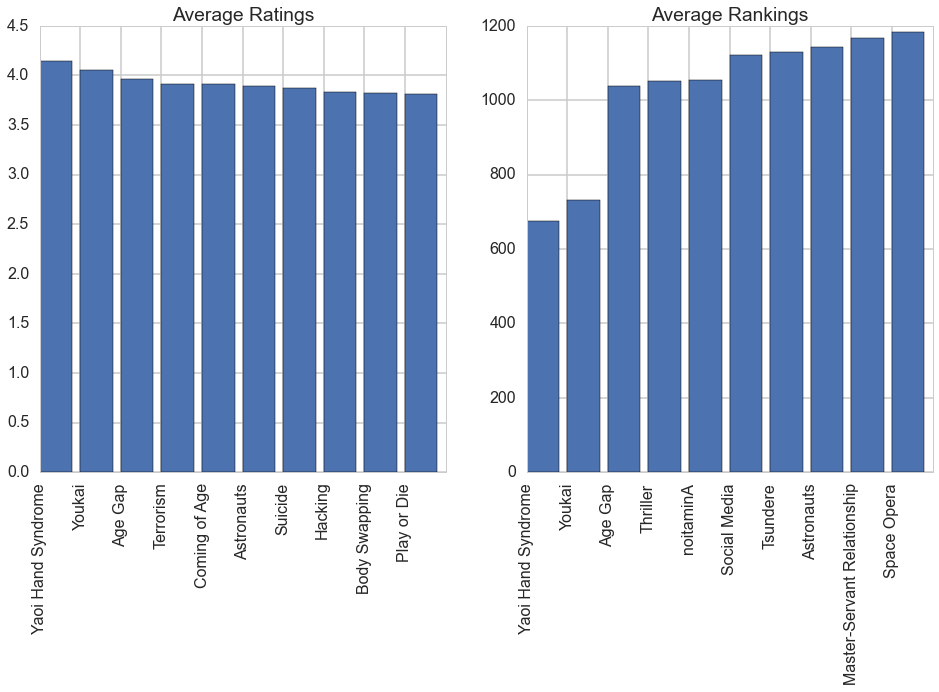

In [70]:
fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(16,8))
x=np.arange(10)
axes[0].bar(x,subd_cat_rating.ix[0:10,'Average Ratings'])
axes[0].set_title('Average Ratings')
axes[0].set_xticks(x)
axes[0].set_xticklabels(subd_cat_rating.index.values[0:10], rotation=90)
axes[1].bar(x,subd_cat_rank.ix[0:10,'Average Rankings'])
axes[1].set_title('Average Rankings')
axes[1].set_xticks(x)
axes[1].set_xticklabels(subd_cat_rank.index.values[0:10], rotation=90)


# Fitting models

## Model 1:

Fit linear regression models with all possible predictors, not including number of votes
We don't include number of votes because in the future, we want to make predictions of new release animes that have no ratings or rankings yet to audience and number of votes would have required reviews and ratings from the audience

In [71]:
# Create dataframe with all possible predictors
df=pd.DataFrame(data["rank"], data.index.values)
df["rate"]=data["ratings"]
df["tlength"]= data["tlength"]
df["type"]=data["type"]
df["studio"]=data["studio"]
df["date_pub"]=data["date_pub"]
df["categories"]=data["categories"]
df.head(5)

,rank,rate,tlength,type,studio,date_pub,categories
(Making of) Evangelion: Another Impact,5996,1.743,6,\nWeb,Studio Khara,2015,"[Sci Fi, CG Animation, Japan Animator's Exhibi..."
+A-Channel,2398,3.334,22,\nDVDSpecial,Studio Gokumi,2011,"[Comedy, Slice of Life, Based on a Manga]"
.hack//G.U. Returner,2504,3.291,0,\nOVA,NaN,2007,"[MMORPG, RPG, Virtual Reality]"
.hack//G.U. Trilogy,1576,3.671,93,\nMovie,NaN,2008,"[CG Animation, MMORPG, RPG, Virtual Reality]"
.hack//G.U. Trilogy Parody,3993,2.691,6,\nDVDSpecial,NaN,2008,"[Comedy, MMORPG, RPG, Virtual Reality]"


In [72]:
df[1:10]

,rank,rate,tlength,type,studio,date_pub,categories
+A-Channel,2398,3.334,22,\nDVDSpecial,Studio Gokumi,2011,"[Comedy, Slice of Life, Based on a Manga]"
.hack//G.U. Returner,2504,3.291,0,\nOVA,NaN,2007,"[MMORPG, RPG, Virtual Reality]"
.hack//G.U. Trilogy,1576,3.671,93,\nMovie,NaN,2008,"[CG Animation, MMORPG, RPG, Virtual Reality]"
.hack//G.U. Trilogy Parody,3993,2.691,6,\nDVDSpecial,NaN,2008,"[Comedy, MMORPG, RPG, Virtual Reality]"
.hack//GIFT,4108,2.646,0,\nOVA,BEE TRAIN,2003,"[Chibi, MMORPG, RPG, Virtual Reality]"
.hack//LIMINALITY,3073,3.064,0,\nOVA,BEE TRAIN,2002,NaN
.hack//Legend Of The Twilight,3039,3.078,0,\nTV,BEE TRAIN,2003,"[Sci Fi, MMORPG, RPG, Virtual Reality]"
.hack//Quantum,974,3.933,0,\nOVA,Kinema Citrus,2010,"[Action, Mystery, Sci Fi, MMORPG]"
.hack//Quantum Specials,3441,2.916,9,\nDVDSpecial,Kinema Citrus,2011,NaN


In [73]:
df.shape

(7281, 7)

In [74]:
df = df[df.rate>0]
df = df[df.tlength>0]
df.shape

(3353, 7)

In [75]:
df[200:300]

,rank,rate,tlength,type,studio,date_pub,categories
Ark IX,5986,1.748,11,\nOVA,Hoods Entertainment,2013,"[Based on a Light Novel, Post-apocalyptic]"
Armitage III Dual-Matrix,2207,3.411,90,\nMovie,AIC,2002,"[Action, Sci Fi, Androids, Cyberpunk, Original..."
Armitage III Poly-Matrix,2038,3.481,95,\nMovie,AIC,1997,"[Action, Sci Fi, Androids, Cyberpunk, Original..."
Armored Trooper Votoms Case;Irvine,3002,3.092,50,\nOVA,Sunrise,2010,[Original Work]
Armored Trooper Votoms: Alone Again,2318,3.367,50,\nOVA,Sunrise,2011,[Original Work]
Armored Trooper Votoms: Big Battle,3365,2.946,60,\nOVA,Sunrise,1986,"[Action, Mecha, Sci Fi, Original Work]"
Armored Trooper Votoms: Pailsen Files Movie,2257,3.390,118,\nMovie,The Answer Studio,2009,[Original Work]
Armored Trooper Votoms: Phantom Arc,2758,3.189,150,\nOVA,Sunrise,2010,[Original Work]
Armored Trooper Votoms: Red Shoulder Document - Roots of Treachery,2486,3.298,60,\nOVA,Sunrise,1988,"[Action, Mecha, Sci Fi, Military, Original Work]"
Around,5663,1.941,3,\nMovie,Ryu Kato Film Works,2007,"[Original Work, Shorts]"


In [76]:
for row in df.index:
    c=data.ix[row,"categories"]
    if type(c)==float:
        df.drop(row, inplace=True)
    else:
        s=data.ix[row,"studio"]
        if type(s)==float:
            df.drop(row, inplace=True)


In [77]:
# fit functions without categories (categories include several different categories and hence would complicate estimations)
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
ols_model = ols('rank ~ tlength + type +  date_pub', df).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     61.89
Date:                Wed, 09 Dec 2015   Prob (F-statistic):          5.31e-101
Time:                        20:43:23   Log-Likelihood:                -18879.
No. Observations:                2135   AIC:                         3.778e+04
Df Residuals:                    2125   BIC:                         3.783e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              1.1e+05   7657.881     14.367      0.000       9.5e+04  1.25e+05
type[T.
Movie]       -995.4956    125.311     -7.944      0.000     -1241.241  -749.750
type[T.
MusicVideo]   781.3022    317.834      2.458      0.014       158.003  1404.601
type[T.
OVA]          200.2571    130.216      1.538      0.124       -55.107   455.621
type[T.
Other]        443.5290    207.290      2.140      0.032        37.016   850.042
type[T.
TV]          1490.0640    151.847      9.813      0.000      1192.280  1787.847
type[T.
TVSpecial]   -275.4453    161.074     -1.710      0.087      -591.324    40.433
type[T.
Web]         1624.8993    168.065      9.668      0.000      1295.310  1954.489
tlength                -1.1055      0.176     -6.279      0.000        -1.451    -0.760
date_pub              -53.2334      3.810    -13.973      0.000       -60.705   -45.762
==============================================================================
Omnibus:                      155.934   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.591
Skew:                           0.150   Prob(JB):                     1.15e-13
Kurtosis:                       2.239   Cond. No.                     4.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
# Very low R^2 value, pretty bad model, but somewhat reasonable in realistically 
# Try dropping type, since some coefficients are not statistically significant (p <0.05)
ols_model1 = ols('rank ~ tlength + date_pub', df).fit()
ols_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     20.25
Date:                Wed, 09 Dec 2015   Prob (F-statistic):           1.95e-09
Time:                        20:43:23   Log-Likelihood:                -19108.
No. Observations:                2135   AIC:                         3.822e+04
Df Residuals:                    2132   BIC:                         3.824e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4.723e+04   7489.567      6.307      0.000      3.25e+04  6.19e+04
tlength       -0.5362      0.187     -2.869      0.004        -0.903    -0.170
date_pub     -21.9153      3.737     -5.864      0.000       -29.245   -14.586
==============================================================================
Omnibus:                     1488.837   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.556
Skew:                           0.080   Prob(JB):                     3.30e-28
Kurtosis:                       1.818   Cond. No.                     3.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared value drops significantly, including type is better. It seems like most predictors are statistically significant but are not enough to explain the variations in rank

Same modeling techniques but this time to predict ratings

In [79]:
ols_model3 = ols('rate ~ tlength + type +  date_pub', df).fit()
ols_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     62.36
Date:                Wed, 09 Dec 2015   Prob (F-statistic):          1.02e-101
Time:                        20:43:23   Log-Likelihood:                -2387.0
No. Observations:                2135   AIC:                             4794.
Df Residuals:                    2125   BIC:                             4851.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             -43.3678      3.383    -12.818      0.000       -50.003   -36.733
type[T.
Movie]          0.4385      0.055      7.921      0.000         0.330     0.547
type[T.
MusicVideo]    -0.3191      0.140     -2.272      0.023        -0.594    -0.044
type[T.
OVA]           -0.1011      0.058     -1.757      0.079        -0.214     0.012
type[T.
Other]         -0.1846      0.092     -2.016      0.044        -0.364    -0.005
type[T.
TV]            -0.6669      0.067     -9.941      0.000        -0.798    -0.535
type[T.
TVSpecial]      0.1126      0.071      1.583      0.114        -0.027     0.252
type[T.
Web]           -0.7306      0.074     -9.840      0.000        -0.876    -0.585
tlength                 0.0005   7.78e-05      6.351      0.000         0.000     0.001
date_pub                0.0231      0.002     13.728      0.000         0.020     0.026
==============================================================================
Omnibus:                       74.854   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.501
Skew:                          -0.242   Prob(JB):                     2.94e-11
Kurtosis:                       2.443   Cond. No.                     4.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
ols_model4 = ols('rate ~ tlength + date_pub', df).fit()
ols_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     18.82
Date:                Wed, 09 Dec 2015   Prob (F-statistic):           7.93e-09
Time:                        20:43:23   Log-Likelihood:                -2618.5
No. Observations:                2135   AIC:                             5243.
Df Residuals:                    2132   BIC:                             5260.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -15.5835      3.314     -4.703      0.000       -22.082    -9.085
tlength        0.0002   8.27e-05      2.902      0.004      7.78e-05     0.000
date_pub       0.0092      0.002      5.591      0.000         0.006     0.012
==============================================================================
Omnibus:                      282.006   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.912
Skew:                          -0.181   Prob(JB):                     1.63e-18
Kurtosis:                       2.112   Cond. No.                     3.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Low R-squared value in model3
R-squared value drops significantly, including type is better. It seems like most predictors are statistically significant but are not enough to explain the variations in rank

## Model 2:

Attempted to fit models based on time intervals, since there might be significant differences in trends and types of animes decades to decades

In [81]:
years=[
    (1930,1940),
    (1940,1950),
    (1950,1960),
    (1960,1970),
    (1970,1980),
    (1980,1990),
    (1990,2000),
    (2000,2010),
    (2010,2020)]

In [82]:
dict_y=dict()
for year in years:
    temp_df=df[(df.date_pub>=year[0]) & (df.date_pub<=year[1])]
    dict_y[year]=temp_df

In [83]:
dict_y[(1990,2000)]

,rank,rate,tlength,type,studio,date_pub,categories
1+2=Paradise,6187,1.623,60,\nOVA,J.C.Staff,1990,"[Comedy, Ecchi, Based on a Manga, Gynophobia, ..."
1001 Nights,4719,2.395,24,\nMovie,Mushi Pro,1998,"[Fantasy, Romance, Abstract, Original Work]"
2112: The Birth of Doraemon,4263,2.582,31,\nMovie,Shinei Animation,1995,"[Based on a Manga, Family Friendly]"
3 x 3 Eyes,2994,3.095,120,\nOVA,Toei Animation,1991,"[Action, Fantasy, Seinen, Based on a Manga, De..."
8 Man After,4677,2.413,100,\nOVA,J.C.Staff,1993,"[Action, Sci Fi, Based on a Manga, Cyborgs, Po..."
A Wind Named Amnesia,3492,2.895,80,\nMovie,MADHOUSE,1990,"[Sci Fi, Based on a Light Novel, Post-apocalyp..."
Abashiri Family,5724,1.903,80,\nOVA,Studio Pierrot,1991,"[Action, Comedy, Ecchi, Based on a Manga, Hand..."
Adachigahara,5190,2.178,25,\nMovie,Tezuka Productions,1991,[Based on a Manga]
"Adventures of Mini-Goddess, The",4143,2.633,336,\nTV,OLM,1998,"[Comedy, Fantasy, Based on a Manga, Chibi, Magic]"
Agent Aika: Special Trial,5661,1.942,10,\nDVDSpecial,Studio Fantasia,1998,"[Action, Comedy, Ecchi, Sci Fi, Original Work,..."


In [84]:
dict_f=dict()
r2=[]
nrow=[]
for year in years:
    if (dict_y[year].shape[0]>1):
        temp_df=dict_y[year]
        ols_model2 = ols('rank ~ tlength + type + date_pub', temp_df).fit()
        dict_f[year]=ols_model2
        r2.append(ols_model2.rsquared)
        nrow.append(dict_y[year].shape[0])
        

In [85]:
subd_fit=pd.DataFrame(r2,dict_f.keys())
subd_fit.columns=["R-squared"]
subd_fit['nrow']=nrow
subd_fit=subd_fit.sort()
subd_fit

,R-squared,nrow
"(1950, 1960)",0.254418,20
"(1960, 1970)",0.707574,5
"(1970, 1980)",0.299553,831
"(1980, 1990)",0.140198,850
"(1990, 2000)",0.240956,57
"(2000, 2010)",0.282402,335
"(2010, 2020)",0.222452,234


No significant improvement, higher R-squared is due to smaller number of data -> less variation

In [86]:
# fitting ratings based on predictors

dict_f1=dict()
r2_1=[]
nrow_1=[]
for year in years:
    if (dict_y[year].shape[0]>1):
        temp_df=dict_y[year]
        ols_model2 = ols('rate ~ tlength + type + date_pub', temp_df).fit()
        dict_f1[year]=ols_model2
        r2_1.append(ols_model2.rsquared)
        nrow_1.append(dict_y[year].shape[0])
        

In [87]:
subd_fit_rat=pd.DataFrame(r2_1,dict_f1.keys())
subd_fit_rat.columns=["R-squared"]
subd_fit_rat['nrow']=nrow_1
subd_fit_rat=subd_fit_rat.sort()
subd_fit_rat

,R-squared,nrow
"(1950, 1960)",0.319132,20
"(1960, 1970)",0.706471,5
"(1970, 1980)",0.303069,831
"(1980, 1990)",0.142938,850
"(1990, 2000)",0.248345,57
"(2000, 2010)",0.281189,335
"(2010, 2020)",0.215399,234


No significant improvement, higher R-squared is due to smaller number of data -> less variation

## Model 3

New models including categories to see if R-square improves

In [88]:
def categories_list(s):
    if type(s) == float:
        return []
    else:
        return s.translate(None, "[]").split(', ')

In [89]:
l = []
for a in data.categories:
    l.append(categories_list(a))
data['categories_list'] = l
categories = set()
for anime in data.categories_list:
        categories.update(i for i in anime)
categories = list(categories)
categories.sort()

In [90]:
for c in categories:
    data[c] = [c in anime for anime in data.categories_list]

In [91]:
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps,emin,tlength,type,categories_list,Abstract,Action,Adventure,Age Gap,Age Transformation,Agriculture,Alice in Wonderland,Aliens,America,Androids,Angels,Animal Abuse,Animal Protagonists,Anime Bancho,Anime Industry,Anime Mirai,Arranged Marriage,Assassins,Astronauts,Aviation,Baseball,Based on a Card Game,Based on a Comic Book,Based on a Doujinshi,Based on a Fairy Tale,Based on a Light Novel,Based on a Manga,Based on a Movie,Based on a Non-Fiction Work,Based on a Novel,Based on a TV Series,Based on a Video Game,...,Science,Seinen,Sexual Abuse,Sexual Content,Shinigami,Shorts,Shoujo,Shoujo-ai,Shounen,Shounen-ai,Slice of Life,Soccer,Social Media,Space Opera,Space Pirates,Sports,Steampunk,Stop Motion Animation,Student-Teacher Relationship,Sudden Girlfriend Appearance,Suicide,Supernatural,Superpowers,Survival,Swordplay,Tennis,Terrorism,Thieves,Thriller,Time Travel,Tournaments,Trains,Treasure Hunters,Tsundere,Urban Legend,Vampires,Violence,Virtual Reality,Vocaloid,War,Western,Work Life,World Masterpiece Theater,World War 2,Yaoi,Yaoi Hand Syndrome,Youkai,Yuri,Zombies,noitaminA
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1,6,6,\nWeb,"[Sci Fi, CG Animation, Japan Animator's Exhibi...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11,2,22,\nDVDSpecial,"[Comedy, Slice of Life, Based on a Manga]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1,0,0,\nOVA,"[MMORPG, RPG, Virtual Reality]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1,93,93,\nMovie,"[CG Animation, MMORPG, RPG, Virtu

In [92]:
# Calculate new ratings based on average of movies'categories' averages 
mov_cat=defaultdict(int)
mov_cat_count=defaultdict(int)
mov_cat_rate=defaultdict(int)

for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        mov_cat[row]+= 0
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(", ")
        for word in n:
            mov_cat[row] += cat_rat_avg[word]
            mov_cat_count[row] +=1 #only count when there's a rating
            

In [93]:
# Calculate a "score" for categories' combinations
for row in data.index:
    if(mov_cat_count[row]>0):
        mov_cat_rate[row]=mov_cat[row]/mov_cat_count[row]
    else:
        mov_cat_rate[row]=0
subd_cat_rate=pd.DataFrame([mov_cat_rate]).T
subd_cat_rate.columns=["Average Ratings"]
subd_cat_rate.head(5)


,Average Ratings
(Making of) Evangelion: Another Impact,2.358749
+A-Channel,2.951899
.hack//G.U. Returner,3.060812
.hack//G.U. Trilogy,2.825134
.hack//G.U. Trilogy Parody,3.019492


In [94]:
df["Cat_Rate"]=subd_cat_rate["Average Ratings"]
df.head(3)

,rank,rate,tlength,type,studio,date_pub,categories,Cat_Rate
(Making of) Evangelion: Another Impact,5996,1.743,6,\nWeb,Studio Khara,2015,"[Sci Fi, CG Animation, Japan Animator's Exhibi...",2.358749
+A-Channel,2398,3.334,22,\nDVDSpecial,Studio Gokumi,2011,"[Comedy, Slice of Life, Based on a Manga]",2.951899
.hack//Roots,2198,3.414,624,\nTV,BEE TRAIN,2006,"[MMORPG, RPG, Virtual Reality]",3.060812


In [95]:
ols_model_cat = ols('rate ~ tlength + type +  date_pub + Cat_Rate', df).fit()
ols_model_cat.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     102.0
Date:                Wed, 09 Dec 2015   Prob (F-statistic):          8.49e-173
Time:                        20:43:28   Log-Likelihood:                -2218.6
No. Observations:                2135   AIC:                             4459.
Df Residuals:                    2124   BIC:                             4522.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             -40.4003      3.131    -12.902      0.000       -46.541   -34.260
type[T.
Movie]          0.4036      0.051      7.881      0.000         0.303     0.504
type[T.
MusicVideo]    -0.1931      0.130     -1.486      0.138        -0.448     0.062
type[T.
OVA]           -0.1649      0.053     -3.094      0.002        -0.269    -0.060
type[T.
Other]          0.0359      0.085      0.420      0.675        -0.132     0.203
type[T.
TV]            -0.5792      0.062     -9.314      0.000        -0.701    -0.457
type[T.
TVSpecial]      0.0361      0.066      0.548      0.584        -0.093     0.165
type[T.
Web]           -0.3875      0.071     -5.460      0.000        -0.527    -0.248
tlength                 0.0004   7.22e-05      5.238      0.000         0.000     0.001
date_pub                0.0201      0.002     12.853      0.000         0.017     0.023
Cat_Rate                1.0562      0.055     19.050      0.000         0.948     1.165
==============================================================================
Omnibus:                       28.831   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.172
Skew:                          -0.224   Prob(JB):                     2.07e-06
Kurtosis:                       2.693   Cond. No.                     4.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-square improves to ~0.3. This model, including a "score" for categories, explains the variations in rate better!

In [96]:
# Calculate new rankings based on average of movies'categories' averages 
mov_catr=defaultdict(int)
mov_cat_countr=defaultdict(int)
for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        mov_catr[row]+= 0
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(", ")
        for word in n:
            mov_catr[row] += cat_rank_avg[word]
            mov_cat_countr[row] +=1 #only count when there's a rating
            

In [97]:
# Calculate a "score" for categories' combinations
mov_cat_rank=defaultdict(int)
for row in data.index:
    if(mov_cat_count[row]>0):
        mov_cat_rank[row]=mov_catr[row]/mov_cat_countr[row]
    else:
        mov_cat_rank[row]=0
subd_cat_rank=pd.DataFrame([mov_cat_rank]).T
subd_cat_rank.columns=["Average Rankings"]
subd_cat_rank.head(5)


,Average Rankings
(Making of) Evangelion: Another Impact,3660.255642
+A-Channel,2447.754744
.hack//G.U. Returner,2243.165852
.hack//G.U. Trilogy,2509.070222
.hack//G.U. Trilogy Parody,2355.008753


In [98]:
df["Cat_Rank"]=subd_cat_rank["Average Rankings"]
df.head(3)

,rank,rate,tlength,type,studio,date_pub,categories,Cat_Rate,Cat_Rank
(Making of) Evangelion: Another Impact,5996,1.743,6,\nWeb,Studio Khara,2015,"[Sci Fi, CG Animation, Japan Animator's Exhibi...",2.358749,3660.255642
+A-Channel,2398,3.334,22,\nDVDSpecial,Studio Gokumi,2011,"[Comedy, Slice of Life, Based on a Manga]",2.951899,2447.754744
.hack//Roots,2198,3.414,624,\nTV,BEE TRAIN,2006,"[MMORPG, RPG, Virtual Reality]",3.060812,2243.165852


In [99]:
ols_model_cat_rank = ols('rank ~ tlength + type +  date_pub + Cat_Rank', df).fit()
ols_model_cat_rank.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     100.2
Date:                Wed, 09 Dec 2015   Prob (F-statistic):          3.61e-170
Time:                        20:43:30   Log-Likelihood:                -18715.
No. Observations:                2135   AIC:                         3.745e+04
Df Residuals:                    2124   BIC:                         3.751e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            8.891e+04   7182.133     12.379      0.000      7.48e+04  1.03e+05
type[T.
Movie]       -786.7504    116.608     -6.747      0.000     -1015.428  -558.073
type[T.
MusicVideo]   512.5637    294.760      1.739      0.082       -65.486  1090.613
type[T.
OVA]          403.3781    121.105      3.331      0.001       165.882   640.874
type[T.
Other]         66.5552    193.062      0.345      0.730      -312.054   445.165
type[T.
TV]          1523.1235    140.668     10.828      0.000      1247.262  1798.985
type[T.
TVSpecial]    -29.6271    149.777     -0.198      0.843      -323.353   264.099
type[T.
Web]          938.7728    159.912      5.871      0.000       625.173  1252.372
tlength                -0.9150      0.163     -5.600      0.000        -1.236    -0.595
date_pub              -44.4806      3.560    -12.495      0.000       -51.462   -37.500
Cat_Rank                1.2448      0.066     18.776      0.000         1.115     1.375
==============================================================================
Omnibus:                       49.492   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.035
Skew:                           0.153   Prob(JB):                     1.82e-07
Kurtosis:                       2.494   Cond. No.                     7.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-square improves with Cat_rank included in the model, compared to the rank model without Cat_rank

In [100]:
# Try include all variables to predict rankings
ols_model_fullrank = ols('rank ~ tlength + type +  date_pub + Cat_Rank + Cat_Rate + rate', df).fit()
ols_model_fullrank.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.850e+04
Date:                Wed, 09 Dec 2015   Prob (F-statistic):               0.00
Time:                        20:43:31   Log-Likelihood:                -13695.
No. Observations:                2135   AIC:                         2.742e+04
Df Residuals:                    2122   BIC:                         2.749e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            1.209e+04    717.998     16.834      0.000      1.07e+04  1.35e+04
type[T.
Movie]         -5.3920     11.308     -0.477      0.634       -27.568    16.784
type[T.
MusicVideo]    60.1792     28.108      2.141      0.032         5.056   115.302
type[T.
OVA]          -24.7689     11.579     -2.139      0.033       -47.476    -2.062
type[T.
Other]         24.4671     18.479      1.324      0.186       -11.772    60.706
type[T.
TV]            -9.7226     13.929     -0.698      0.485       -37.038    17.593
type[T.
TVSpecial]    -18.7827     14.282     -1.315      0.189       -46.791     9.225
type[T.
Web]          -26.9266     15.446     -1.743      0.081       -57.217     3.364
tlength                 0.0082      0.016      0.524      0.600        -0.023     0.039
date_pub               -1.1096      0.352     -3.156      0.002        -1.799    -0.420
Cat_Rank                0.0202      0.013      1.517      0.129        -0.006     0.046
Cat_Rate               12.3838     25.349      0.489      0.625       -37.329    62.096
rate                -2251.1268      4.709   -478.078      0.000     -2260.361 -2241.893
==============================================================================
Omnibus:                     1438.327   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37405.623
Skew:                          -2.786   Prob(JB):                         0.00
Kurtosis:                      22.734   Cond. No.                     7.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

If we include rate into rank equation, R^2 shoots up significantly to 0.894. However, realistically, we can't really know rate for new release anime right after it is released so we would have less information to predict the ranking.

In [101]:
# Try include all variables to predict rankings/ratings
ols_model_fullrate = ols('rate ~ tlength + type +  date_pub + Cat_Rank + Cat_Rate + rank', df).fit()
ols_model_fullrate.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.850e+04
Date:                Wed, 09 Dec 2015   Prob (F-statistic):               0.00
Time:                        20:43:31   Log-Likelihood:                 2795.0
No. Observations:                2135   AIC:                            -5564.
Df Residuals:                    2122   BIC:                            -5490.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               4.9767      0.320     15.538      0.000         4.349     5.605
type[T.
Movie]          0.0011      0.005      0.216      0.829        -0.009     0.011
type[T.
MusicVideo]     0.0248      0.012      1.991      0.047         0.000     0.049
type[T.
OVA]           -0.0126      0.005     -2.455      0.014        -0.023    -0.003
type[T.
Other]          0.0110      0.008      1.346      0.179        -0.005     0.027
type[T.
TV]            -0.0100      0.006     -1.623      0.105        -0.022     0.002
type[T.
TVSpecial]     -0.0081      0.006     -1.284      0.199        -0.020     0.004
type[T.
Web]           -0.0154      0.007     -2.255      0.024        -0.029    -0.002
tlength              7.169e-06   6.94e-06      1.032      0.302     -6.45e-06  2.08e-05
date_pub               -0.0003      0.000     -1.983      0.047        -0.001 -3.42e-06
Cat_Rank             6.588e-06   5.89e-06      1.118      0.264     -4.97e-06  1.81e-05
Cat_Rate                0.0113      0.011      1.010      0.313        -0.011     0.033
rank                   -0.0004   9.21e-07   -478.078      0.000        -0.000    -0.000
==============================================================================
Omnibus:                     1545.625   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46070.293
Skew:                          -3.053   Prob(JB):                         0.00
Kurtosis:                      24.923   Cond. No.                     1.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

If we include rank into rate equation, R^2 shoots up significantly to 0.895. However, realistically, we can't really know rank for new release anime right after it is released so we would have less information to predict the rating.

# Comments

7281 data points
*Tlength = number of episodes x minutes/episode

DATA EXPLORATORY:

Studios:
-	Strong correlation between frequency and average ratings: higher frequency (number of studios that anime come from, higher the ratings) -> can also indicate bias that studios produce better movies are more popular, produce more popular animes, and hence have more ratings since the animes are more well-known
-	Much greater variation in frequency compared to differences among average ratings among animes
-	No correlation between ratings and rankings. The top 10 rankings don’t overlap with top 10 ratings generally

Types: 
-	Same as studios but there’s strong correlation between average ratings and rankings. The lists are exactly the same in the same order. 

Tlengths:
-	Most movies tends to have length of less than 100 minutes in total- cluster toward lower lengths, with some outliers
-	No systematic correlation between tlengths and ratings/rankings

Episodes:
-	Most movies have under 50 episodes, with lots of clusters around 1 episode, 15-20 episodes, 20-25 episodes, and 50-55 episodes
-	No systematic correlation with ratings and rankings

Votes:
-	More votes -> higher ratings -> lower ranks (higher place) 
-	Votes and ratings/rankings are curve graphs

Date_pub:
-	Small clusters around 1930s -> lots of animes in this period have very high ranks (bad ranking)
-	But closer to the recent dates tend to generally have a bit better rankings (low ranks) but pretty random

Categories:
-	Some overlapping between ratings and rankings (esp for top ratings ones and top ranks) but less later in top 10
-	Frequency doesn’t correlate with ratings and rankings at all – VERY DIFFERENT LISTS

FITTING MODELS:

-   R^2/Adjusted R^2 value is so small, yet all the predictors seem to be statistically significant. Perhaps this suggests that we don't have enough predictors to explain variations in ranks and ratings.
-   Cluster data based on decades/time intervals don't significantly improve the data much
-   Include a score to quanitfy combination of categories help improve R^2/Adjusted R^2
-   Include rank to predict rate and include rate to predict rank help increase R^2 and adjusted R^2 dramatically